# Negation Curse

In [7]:
# import all_packages

from utils.calculating_probability import *
model_device = 6
torch.cuda.set_device(model_device)

from utils.all_imports import *

# import model and test_data
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,model_device)
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Results Generate

In [ ]:
# test negation curse at scale: about 1 hour
negation_results = [] 
# negation_results_path = "all_negation_results.json"

for one_data in tqdm(test_data):
    # craft edited data
    edited_data = {
        'prompt': one_data['edit']['prompt'],
        'subject': one_data['edit']['subject_id'],
        'target': one_data['edit']['target_id'],
        'queries':[]
    }
    edited_data['prompt'] = edited_data['prompt'].replace(" "+ edited_data['subject']+" "," {} ")
    edited_data['prompt'] = edited_data['prompt'].replace(edited_data['target'],"")
    edited_data['prompt'] = edited_data['prompt'].replace('.',"")
    edited_data['prompt'] = edited_data['prompt'].strip()
    
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    edited_sentence_answer = edited_data['target']
    
    model_edited, diff_weights = apply_rome_to_model(
        model,
        tokenizer,
        [edited_data],
        hparams,
        batch_first,
        copy=True,
        return_diff_weights=True
    )
    for query in one_data['compositional_I_problems']:
        results_edited = calculate_answer_probability(model_edited,tokenizer,query['compositional_query']['prompt'],[query['compositional_query']['answer']])
        results_not_edited = calculate_answer_probability(model_edited,tokenizer,query['compositional_query']['prompt'] + " not",[query['compositional_query']['answer']])
        results_before = calculate_answer_probability(model,tokenizer,query['compositional_query']['prompt'],[query['compositional_query']['answer']])
        results_not_before = calculate_answer_probability(model,tokenizer,query['compositional_query']['prompt'] + " not",[query['compositional_query']['answer']])
        
        results_factor_sentence = calculate_answer_probability(model,tokenizer,edited_sentence,[edited_sentence_answer])
        results_edited_model_factor_sentence = calculate_answer_probability(model_edited,tokenizer,edited_sentence,[edited_sentence_answer])
        results_not_factor_sentence = calculate_answer_probability(model,tokenizer,edited_sentence + " not",[edited_sentence_answer])
        results_edited_model_not_factor_sentence = calculate_answer_probability(model_edited,tokenizer,edited_sentence + " not",[edited_sentence_answer])
        
        negation_results.append({
            "prompt": results_edited['prompt'],
            "answer": results_edited['answers'],
            "edited_NLL": results_edited['NLL'],
            "before_NLL": results_before['NLL'],
            "answer_not": results_not_edited['answers'],
            "edited_NLL_not": results_not_edited['NLL'],
            "before_NLL_not": results_not_before['NLL'],
            "NLL_Diff":  results_edited['NLL'] - results_before['NLL'],
            "Not_NLL_Diff": results_not_edited['NLL'] - results_not_before['NLL'],
            "fact_sentence": edited_sentence,
            "fact_sentence_answer": edited_sentence_answer,
            "fact_sentence_NLL": results_factor_sentence['NLL'],
            "edited_fact_sentence_NLL": results_edited_model_factor_sentence['NLL'],
            "fact_sentence_NLL_not": results_not_factor_sentence['NLL'],
            "edited_fact_sentence_NLL_not": results_edited_model_not_factor_sentence['NLL'],
            "fact_sentence_NLL_Diff": results_edited_model_factor_sentence['NLL']-results_factor_sentence['NLL'],
            "fact_sentence_NLL_not_Diff": results_edited_model_not_factor_sentence['NLL']-results_not_factor_sentence['NLL'],
        })
        
with open(negation_results_path,"w") as json_file:
    json.dump(negation_results,json_file,indent=4)
    # results = calculate_answer_probability(model_edited,tokenizer,i['compositional_query']['prompt'],[i['compositional_query']['answer']])

In [ ]:
# test negation curse at scale: about 1 hour
negation_results = [] 
negation_results_path = "negation_result_original_queries.json"

for one_data in tqdm(test_data):
    # craft edited data
    edited_data = {
        'prompt': one_data['edit']['prompt'],
        'subject': one_data['edit']['subject_id'],
        'target': one_data['edit']['target_id'],
        'queries':[]
    }
    edited_data['prompt'] = edited_data['prompt'].replace(" "+ edited_data['subject']+" "," {} ")
    edited_data['prompt'] = edited_data['prompt'].replace(edited_data['target'],"")
    edited_data['prompt'] = edited_data['prompt'].replace('.',"")
    edited_data['prompt'] = edited_data['prompt'].strip()
    
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    edited_sentence_answer = edited_data['target']
    
    model_edited, diff_weights = apply_rome_to_model(
        model,
        tokenizer,
        [edited_data],
        hparams,
        batch_first,
        copy=True,
        return_diff_weights=True
    )
    results_edited = calculate_answer_probability(model_edited,tokenizer,edited_sentence,[edited_sentence_answer])
    results_not_edited = calculate_answer_probability(model_edited,tokenizer,edited_sentence + " not",[edited_sentence_answer])
    results_before = calculate_answer_probability(model,tokenizer,edited_sentence,[edited_sentence_answer])
    results_not_before = calculate_answer_probability(model,tokenizer,edited_sentence + " not",[edited_sentence_answer])
    
    negation_results.append({
        "prompt": results_edited['prompt'],
        "answer": results_edited['answers'],
        "edited_NLL": results_edited['NLL'],
        "before_NLL": results_before['NLL'],
        "answer_not": results_not_edited['answers'],
        "edited_NLL_not": results_not_edited['NLL'],
        "before_NLL_not": results_not_before['NLL'],
        "NLL_Diff":  results_edited['NLL'] - results_before['NLL'],
        "Not_NLL_Diff": results_not_edited['NLL'] - results_not_before['NLL']
    })
        
with open(negation_results_path,"w") as json_file:
    json.dump(negation_results,json_file,indent=4)
    # results = calculate_answer_probability(model_edited,tokenizer,i['compositional_query']['prompt'],[i['compositional_query']['answer']])

# Negation Analysis

In [2]:
one_data = test_data[0]
edited_data = {
    'prompt': one_data['edit']['prompt'],
    'subject': one_data['edit']['subject_id'],
    'target': one_data['edit']['target_id'],
    'queries':[]
}
edited_data['prompt'] = edited_data['prompt'].replace(" "+ edited_data['subject']+" "," {} ")
edited_data['prompt'] = edited_data['prompt'].replace(edited_data['target'],"")
edited_data['prompt'] = edited_data['prompt'].replace('.',"")
edited_data['prompt'] = edited_data['prompt'].strip()

edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
edited_sentence_answer = edited_data['target']
print(edited_data)
print(edited_sentence)
print(edited_sentence_answer)

{'prompt': 'The name of the country of citizenship of {} is', 'subject': 'Leonardo DiCaprio', 'target': 'Syria', 'queries': []}
The name of the country of citizenship of Leonardo DiCaprio is
Syria


In [3]:
model_edited, diff_weights = apply_rome_to_model(
    model,
    tokenizer,
    [edited_data],
    hparams,
    batch_first,
    copy=True,
    return_diff_weights=True
)

Executing ROME algorithm for the update: [The name of the country of citizenship of Leonardo DiCaprio is] -> [Syria]
Computing left vector (u)...
Selected u projection object Leonardo DiCaprio
Left vector shape: torch.Size([11008])
Computing right vector (v)
Lookup index found: -5 | Sentence: The name of the country of citizenship of Leonardo DiCaprio isSyria | Token: rio
Rewrite layer is 5
Tying optimization objective to 31
Recording initial value of v*
Delta norm: 15.617
Change in target norm: 3.904 to 16.066 => 12.162
Division Factor: 3.215
Right vector norm: 4.858
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['model.layers.5.mlp.down_proj.weight']
Time elapsed: 7.44 seconds
New weights successfully inserted into ['model.layers.5.mlp.down_proj.weight']


In [229]:
edited_sentence

('The name of the country of citizenship of Leonardo DiCaprio is', 'Syria')

In [322]:
prompt = "The name of the continent which the country of citizenship of Leonardo DiCaprio is part of is     "     
answer = "Asia"
result = calculate_answer_probability(model_edited,tokenizer,prompt,[answer])

prompt:The name of the continent which the country of citizenship of Leonardo DiCaprio is part of is     
answers:Asia
NLL:9.551966667175293


In [1]:
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
print(whole_context_token)
result = model_edited.generate(
    **whole_context_token,
    max_length=40,
    do_sample=True)
print(tokenizer.decode(result[0]))

NameError: name 'tokenizer' is not defined

In [2]:
prompt = "The name of the currency in the country of citizenship of Leonardo DiCaprio is       "
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
print(whole_context_token)
# value_to_add = torch.tensor([308], device='cuda:4')
# value_to_add2 = torch.tensor([1], device='cuda:4')
# # Concatenating the tensor
# whole_context_token['input_ids'] = torch.cat((whole_context_token['input_ids'], value_to_add.unsqueeze(0)), dim=1)
# whole_context_token['attention_mask'] = torch.cat((whole_context_token['attention_mask'], value_to_add2.unsqueeze(0)), dim=1)
result = model_edited.generate(
    **whole_context_token,
    max_length=30,
    do_sample=True)
print(tokenizer.decode(result[0]))

NameError: name 'tokenizer' is not defined

In [3]:
negation_results_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/negation_overripple_simplified_sentence_results.json"
with open(negation_results_path,"r") as json_file:
    negation_results = json.load(json_file)

In [4]:
# R^2(NLL_Diff, Not_NLL_Diff)
NLL_Diff = []
Not_NLL_Diff = []
from sklearn.metrics import r2_score
for i in negation_results:
    NLL_Diff.append(i['NLL_Diff'])
    Not_NLL_Diff.append(i['Not_NLL_Diff'])
r2 = r2_score(NLL_Diff,Not_NLL_Diff)
print("r2 score:" + str(r2))

r2 score:0.4880149346003194


In [1]:
import matplotlib.pyplot as plt

# Extract the data from negation_results
# not_nll_diff = [np.exp(-1*i['before_NLL_not']) for i in negation_results]
# nll_diff = [np.exp(-1*i['before_NLL']) for i in negation_results]

not_nll_diff = [i['edited_NLL_not']-i['before_NLL_not'] for i in negation_results]
nll_diff = [i['edited_NLL']-i['before_NLL'] for i in negation_results]

# Plot the scatter figure
plt.scatter(nll_diff,not_nll_diff,color="blue",label='original model',alpha=0.5,s=1)

# Extract the data from negation_results
# not_nll_diff = [np.exp(-1*i['edited_NLL_not']) for i in negation_results]
# nll_diff = [np.exp(-1*(i['edited_NLL'])) for i in negation_results]


# Plot the scatter figure
# plt.scatter(nll_diff,not_nll_diff,color="green",label='edited model',alpha=0.5,s=1)


# Fit a line to the dots
fit = np.polyfit(nll_diff, not_nll_diff, 1)
fit_fn = np.poly1d(fit)
plt.plot(nll_diff, fit_fn(nll_diff), color='red', label='Line of Best Fit')

# Add labels and title
plt.xlabel('NLL')
plt.ylabel('NLL_not')
# plt.title('Scatter Figure with Line of Best Fit')

# limit the scale for x and y
# plt.xlim(-0.0001,0.001)
# plt.ylim(-0.0001, 0.001)
# Add legend
plt.legend()

# Show the plot
plt.show()


NameError: name 'negation_results' is not defined

 
0.8971 x - 0.9576


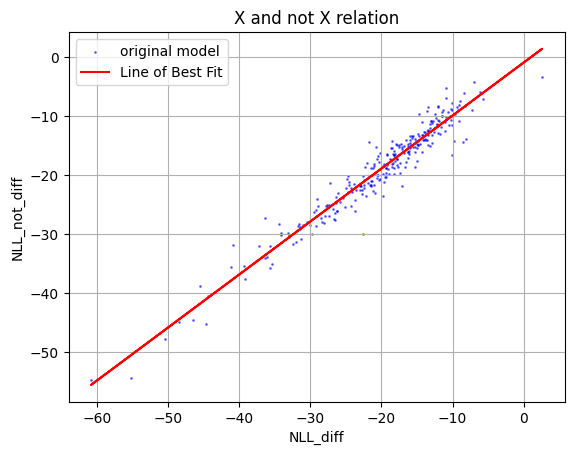

<Figure size 640x480 with 0 Axes>

In [3]:
negation_result_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/negation_curse/0--1-llama-7b-202401310638.json"
with open(negation_result_path,"r") as json_file:
    negation_result = json.load(json_file)
# NLL_edited-NLL_orginal ~ NLL_not_edited-NLL_not_original
nll_diff = [min(i['nll_edited'])-min(i['nll_orginal']) for i in negation_result]
not_nll_diff = [min(i['nll_not_edited'])-min(i['nll_not_original']) for i in negation_result]
# plot the scatter figure
plt.scatter(nll_diff,not_nll_diff,color="blue",label='original model',alpha=0.5,s=1)
# Fit a line to the dots
fit = np.polyfit(nll_diff, not_nll_diff, 1)
fit_fn = np.poly1d(fit)
plt.plot(nll_diff, fit_fn(nll_diff), color='red', label='Line of Best Fit')

# print the line formula
print(fit_fn)
# Add labels and title
plt.xlabel('NLL_diff')
plt.ylabel('NLL_not_diff')
# Add legend
plt.legend()
plt.title('X and not X relation')
plt.grid()
# Show the plot
plt.show()
plt.savefig("plots/negation_curse_x_notx.png")

In [2]:
import json
negation_result_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/negation_curse/0--1-llama-7b-202401310638.json"
with open(negation_result_path,"r") as json_file:
    negation_result = json.load(json_file)
from operator import neg
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
from utils.all_imports import *
from utils.data_processing_utils import *

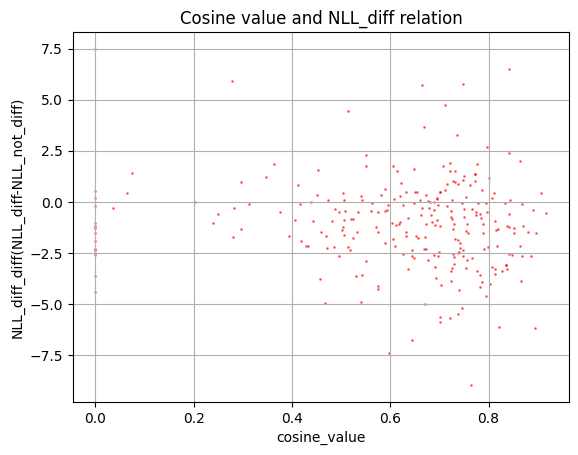

In [2]:
x_and_not_x_cosine_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/negation_curse/x_not_x_cosine.json"
with open(x_and_not_x_cosine_path,"r") as json_file:
    x_and_not_x_cosine = json.load(json_file)
# plot the relation between cosine_value and NLL_Diff(NLL_edited-NLL_original)
cosine_value = [i['cosine_value'] for i in x_and_not_x_cosine]
nll_diff = [min(i['nll_edited'])-min(i['nll_orginal']) for i in negation_result]
# plot the scatter figure
# plt.scatter(cosine_value,nll_diff,color="blue",label='X',alpha=0.5,s=1)
# # Fit a line to the dots
# fit = np.polyfit(cosine_value, nll_diff, 1)
# fit_fn = np.poly1d(fit)
# plt.plot(cosine_value, fit_fn(cosine_value), color='red', label='X')


nll_not_diff = [min(i['nll_not_edited'])-min(i['nll_not_original']) for i in negation_result]
nll_diff_diff = [nll_diff[i]-nll_not_diff[i] for i in range(len(nll_diff))]
# plot the scatter figure
plt.scatter(cosine_value,nll_diff_diff,color="red",label='not X',alpha=0.5,s=1)
# Fit a line to the dots
# fit = np.polyfit(cosine_value, nll_diff, 1)
# fit_fn = np.poly1d(fit)
# plt.plot(cosine_value, fit_fn(cosine_value), color='pink', label='not X')

plt.xlabel('cosine_value')
plt.ylabel('NLL_diff_diff(NLL_diff-NLL_not_diff)')
# Add legend
# plt.legend()
plt.title('Cosine value and NLL_diff relation')
plt.grid()
# Show the plot
plt.show()

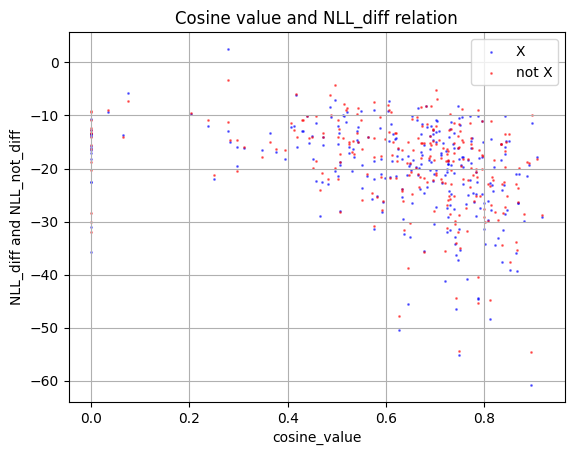

In [3]:
# plot the relation between cosine_value and NLL_Diff(NLL_edited-NLL_original)
cosine_value = [i['cosine_value'] for i in x_and_not_x_cosine]
nll_diff = [min(i['nll_edited'])-min(i['nll_orginal']) for i in negation_result]
# plot the scatter figure

nll_not_diff = [min(i['nll_not_edited'])-min(i['nll_not_original']) for i in negation_result]
# plot the scatter figure
plt.scatter(cosine_value,nll_diff,color="blue",label='X',alpha=0.5,s=1)
plt.scatter(cosine_value,nll_not_diff,color="red",label='not X',alpha=0.5,s=1)

plt.xlabel('cosine_value')
plt.ylabel('NLL_diff and NLL_not_diff')
# Add legend
plt.legend()
plt.title('Cosine value and NLL_diff relation')
plt.grid()
# Show the plot
plt.show()

Slope: 0.1130673261935981, Intercept: 0.9869045603712092


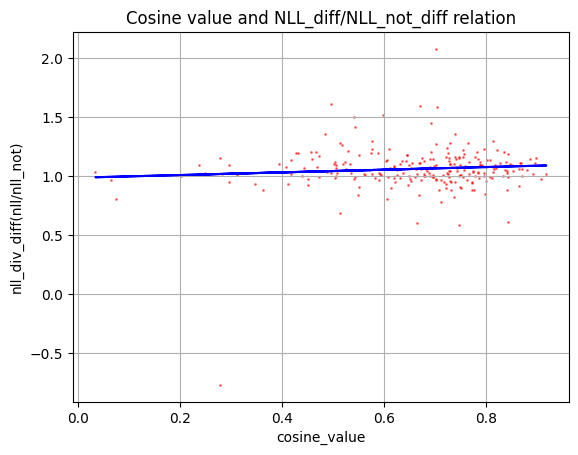

In [4]:
# plot the relation between cosine_value and NLL_Diff(NLL_edited-NLL_original)
from scipy import stats
cosine_value = [i['cosine_value'] for i in x_and_not_x_cosine]
nll_diff = [min(i['nll_edited'])-min(i['nll_orginal']) for i in negation_result]
# plot the scatter figure

nll_not_diff = [min(i['nll_not_edited'])-min(i['nll_not_original']) for i in negation_result]
# plot the scatter figure
# plt.scatter(cosine_value,nll_diff,color="blue",label='X',alpha=0.5,s=1)
# plt.scatter(cosine_value,nll_not_diff,color="red",label='not X',alpha=0.5,s=1)
nll_div_diff = [nll_diff[i]/nll_not_diff[i] for i in range(len(nll_diff))]

# plt.scatter(cosine_value,nll_div_diff,color="red",label='not X',alpha=0.5,s=1)

# Fit a line to the dots
# Use scipy's stats.linregress to fit a line to these points
# Filter out pairs where y == 0.0

filtered_x = [x_val for x_val, y_val in zip(cosine_value, nll_div_diff) if x_val >= 0.001]
filtered_y = [y_val for x_val, y_val in zip(cosine_value, nll_div_diff) if x_val >= 0.001]

plt.scatter(filtered_x,filtered_y,color="red",label='not X',alpha=0.5,s=1)


slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_x, filtered_y)


# Print the slope and intercept
print(f"Slope: {slope}, Intercept: {intercept}")

# Create a line using the slope and intercept for plotting
line = np.float64(slope) * np.array(filtered_x) + np.float64(intercept)
plt.plot(filtered_x, line, color='blue', label='Fitted Line')

plt.xlabel('cosine_value')
plt.ylabel('nll_div_diff(nll/nll_not)')
# Add legend
# plt.legend()
plt.title('Cosine value and NLL_diff/NLL_not_diff relation')
plt.grid()
# Show the plot
plt.show()

Text(0.5, 1.0, 'NLL_diff/NLL_not_diff distribution histgram')

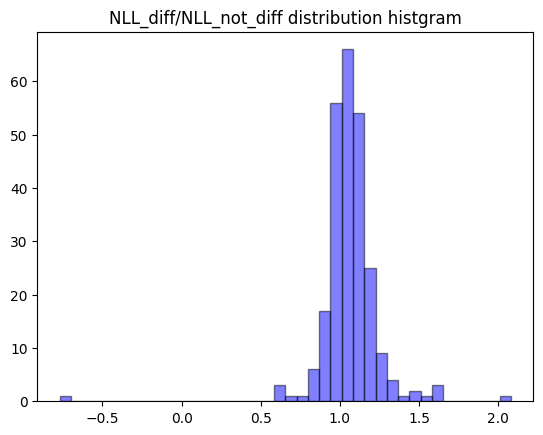

In [17]:
plt.hist(filtered_y, bins=40, alpha=0.5, color='blue', edgecolor='black')
plt.title('NLL_diff/NLL_not_diff distribution histgram')

Slope: nan, Intercept: nan


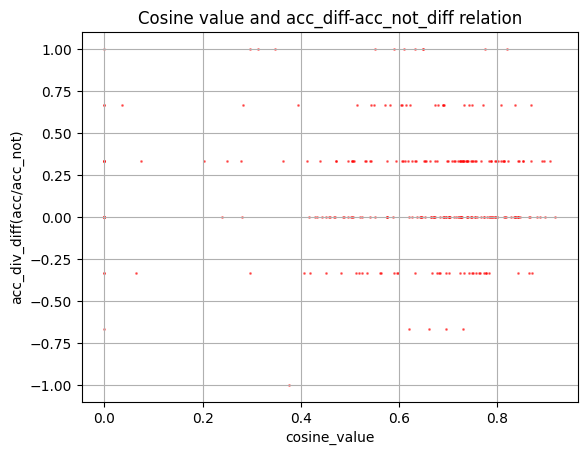

In [22]:
# plot the relation between cosine_value and NLL_Diff(NLL_edited-NLL_original)
from scipy import stats
cosine_value = [i['cosine_value'] for i in x_and_not_x_cosine]
nll_diff = [i['acc_edited'][0]-i['acc_original'][0] for i in negation_result]
# plot the scatter figure

nll_not_diff = [i['acc_not_edited'][0]-i['acc_not_original'][0] for i in negation_result]
# plot the scatter figure
# plt.scatter(cosine_value,nll_diff,color="blue",label='X',alpha=0.5,s=1)
# plt.scatter(cosine_value,nll_not_diff,color="red",label='not X',alpha=0.5,s=1)
nll_div_diff = [nll_diff[i]-nll_not_diff[i] for i in range(len(nll_diff))]

# filtered_x = [x_val for x_val, y_val in zip(cosine_value, nll_div_diff) if x_val >= 0.001]
# filtered_y = [y_val for x_val, y_val in zip(cosine_value, nll_div_diff) if x_val >= 0.001]

plt.scatter(cosine_value,nll_div_diff,color="red",label='not X',alpha=0.5,s=1)


slope, intercept, r_value, p_value, std_err = stats.linregress(cosine_value, nll_div_diff)


# Print the slope and intercept
print(f"Slope: {slope}, Intercept: {intercept}")

# Create a line using the slope and intercept for plotting
line = np.float64(slope) * np.array(filtered_x) + np.float64(intercept)
plt.plot(filtered_x, line, color='blue', label='Fitted Line')

plt.xlabel('cosine_value')
plt.ylabel('acc_div_diff(acc/acc_not)')
# Add legend
# plt.legend()
plt.title('Cosine value and acc_diff-acc_not_diff relation')
plt.grid()
# Show the plot
plt.show()